
# Assemble images with simple image stitching

This example demonstrates how a set of images can be assembled under
the hypothesis of rigid body motions.


In [10]:
from matplotlib import pyplot as plt
import numpy as np
from skimage import data, util, transform, feature, measure, filters, metrics, io
from skimage.color import rgb2gray


def match_locations(img0, img1, coords0, coords1, radius=5, sigma=3):
    """Match image locations using SSD minimization.

    Areas from `img0` are matched with areas from `img1`. These areas
    are defined as patches located around pixels with Gaussian
    weights.

    Parameters
    ----------
    img0, img1 : 2D array
        Input images.
    coords0 : (2, m) array_like
        Centers of the reference patches in `img0`.
    coords1 : (2, n) array_like
        Centers of the candidate patches in `img1`.
    radius : int
        Radius of the considered patches.
    sigma : float
        Standard deviation of the Gaussian kernel centered over the patches.

    Returns
    -------
    match_coords: (2, m) array
        The points in `coords1` that are the closest corresponding matches to
        those in `coords0` as determined by the (Gaussian weighted) sum of
        squared differences between patches surrounding each point.
    """
    y, x = np.mgrid[-radius : radius + 1, -radius : radius + 1]
    weights = np.exp(-0.5 * (x**2 + y**2) / sigma**2)
    weights /= 2 * np.pi * sigma * sigma

    match_list = []
    for r0, c0 in coords0:
        roi0 = img0[r0 - radius : r0 + radius + 1, c0 - radius : c0 + radius + 1]
        roi1_list = [
            img1[r1 - radius : r1 + radius + 1, c1 - radius : c1 + radius + 1]
            for r1, c1 in coords1
        ]
        # sum of squared differences
        ssd_list = [np.sum(weights * (roi0 - roi1) ** 2) for roi1 in roi1_list]
        match_list.append(coords1[np.argmin(ssd_list)])

    return np.array(match_list)

## Data generation

For this example, we generate a list of slightly tilted noisy images.



In [70]:
image1 = io.imread('../data/NUsample/n003-2018-01-02-11-48-43+0800__CAM_BACK__1514864956159109.jpg')
image2 = io.imread('../data/NUsample/n003-2018-01-02-11-48-43+0800__CAM_BACK_LEFT__1514864956197197.jpg')
image3 = io.imread('../data/NUsample/n003-2018-01-02-11-48-43+0800__CAM_FRONT_LEFT__1514864956138205.jpg')
image4 = io.imread('../data/NUsample/n003-2018-01-02-11-48-43+0800__CAM_FRONT__1514864956220368.jpg')
image5 = io.imread("../data/NUsample/n003-2018-01-02-11-48-43+0800__CAM_FRONT_RIGHT__1514864966493989.jpg")
image6 = io.imread("../data/NUsample/n003-2018-01-02-11-48-43+0800__CAM_BACK_RIGHT__1514864936124954.jpg")

image1 = rgb2gray(image1)
image2 = rgb2gray(image2)
image3 = rgb2gray(image3)
image4 = rgb2gray(image4)
image5 = rgb2gray(image5)
image6 = rgb2gray(image6)

img_list = [image1, image2]

ref_img = img_list[0].copy()


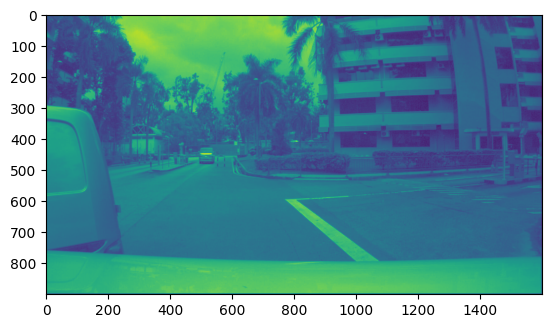

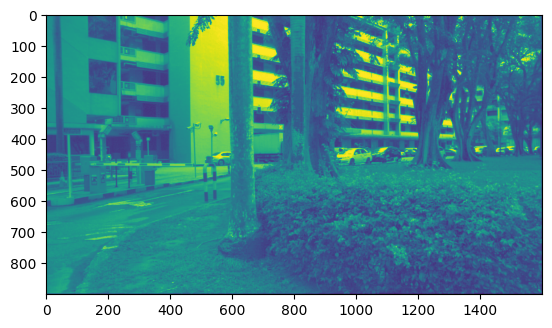

In [71]:
for img in img_list:
    plt.imshow(img)
    plt.show()

## Image registration

<div class="alert alert-info"><h4>Note</h4><p>This step is performed using the approach described in
   `sphx_glr_auto_examples_transform_plot_matching.py`, but any other
   method from the `sphx_glr_auto_examples_registration` section can be
   applied, depending on your problem.</p></div>

Reference points are detected over all images in the list.



In [63]:
min_dist = 3
corner_list = [
    feature.corner_peaks(
        feature.corner_harris(img), threshold_rel=0.001, min_distance=min_dist
    )
    for img in img_list
]

The Harris corners detected in the first image are chosen as
references. Then the detected points on the other images are
matched to the reference points.



In [64]:
img0 = img_list[0]
coords0 = corner_list[0]
matching_corners = [
    match_locations(img0, img1, coords0, coords1, min_dist)
    for img1, coords1 in zip(img_list[1:], corner_list)
]

Once all the points are registered to the reference points, robust
relative affine transformations can be estimated using the RANSAC method.



In [67]:
trfm_list = []
src = np.array(coords0)
for dst in matching_corners:
    trfm_list.append( measure.ransac(
        (dst, src),
        transform.EuclideanTransform,
        min_samples=3,
        residual_threshold=2,
        max_trials=100,
    )[0].params)

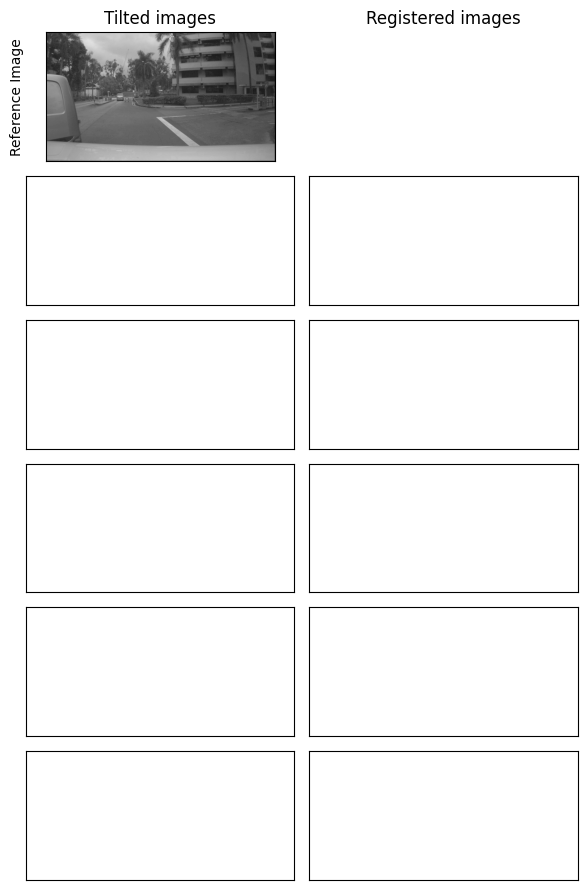

In [69]:
fig, ax_list = plt.subplots(6, 2, figsize=(6, 9), sharex=True, sharey=True)
for idx, (im, trfm, (ax0, ax1)) in enumerate(zip(img_list, trfm_list, ax_list)):
    ax0.imshow(im, cmap="gray", vmin=0, vmax=1)
    ax1.imshow(transform.warp(im, trfm), cmap="gray", vmin=0, vmax=1)

    if idx == 0:
        ax0.set_title("Tilted images")
        ax0.set_ylabel(f"Reference Image\n")
        ax1.set_title("Registered images")

    ax0.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
    ax1.set_axis_off()

fig.tight_layout()

## Image assembling

A composite image can be obtained using the positions of the
registered images relative to the reference one. To do so, we define
a global domain around the reference image and position the other
images in this domain.

A global transformation is defined to move the reference image in the
global domain image via a simple translation:



In [56]:
margin = 50
height, width = img_list[0].shape
out_shape = height + 2 * margin, width + 2 * margin
glob_trfm = np.eye(3)
glob_trfm[:2, 2] = -margin, -margin

Finally, the relative position of the other images in the global
domain are obtained by composing the global transformation with the
relative transformations:



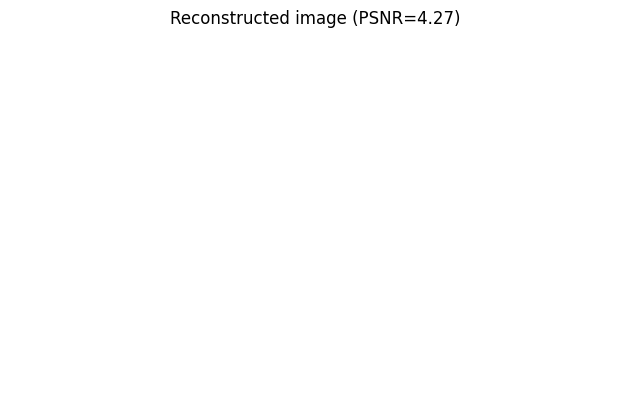

In [57]:
global_img_list = [
    transform.warp(
        img, trfm.dot(glob_trfm), output_shape=out_shape, mode="constant", cval=np.nan
    )
    for img, trfm in zip(img_list, trfm_list)
]

all_nan_mask = np.all([np.isnan(img) for img in global_img_list], axis=0)
global_img_list[0][all_nan_mask] = 1.0

composite_img = np.nanmean(global_img_list, 0)
psnr_composite = metrics.peak_signal_noise_ratio(
    ref_img, composite_img[margin : margin + height, margin : margin + width]
)

fig, ax = plt.subplots(1, 1)

ax.imshow(composite_img, cmap="gray", vmin=0, vmax=1)
ax.set_axis_off()
ax.set_title(f"Reconstructed image (PSNR={psnr_composite:.2f})")
fig.tight_layout()

plt.show()